# Introducing the test models



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

from collections import Counter
from scipy.optimize import linear_sum_assignment

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score, silhouette_score,
    confusion_matrix, classification_report, adjusted_rand_score,
    normalized_mutual_info_score, explained_variance_score
)


## 4.3 Supervised Learning Approach  
(logistic regression, decision tree, Naive Bayes and K-nearest neighbor)


Multinomial Logistic Regression


## 4.4 Unsupervised Learning Approach  
(hard) k-means, fuzzy C-means and Gaussian mixture models. Make use of PCA
for visualization

##### Load and prepare the data


In [3]:
# Load the data feature matrix and labels ## LATER ON WE CAN REMOVE THE PROMPT AND JUST LOAD THE CSV
try:
    df = pd.read_csv("features.csv")
except FileNotFoundError:
    print("Error: features.csv not found. Please ensure the file is in the current directory.")
    exit()

# Identify Non-Feature columns
Non_feat_columns = ['activity', 'trial', 'student', 'window_idx']

#Drop the non-feature columns so that we only have the features left
X = df.drop(columns=Non_feat_columns, errors='ignore')

# We use the activity column for evaluation later (since, during recordings we have labeled each entry with an activity).We don't use it for clustering since K-Means is unsupervised.
y_true = df['activity'].astype('category')
Nr_clusters = y_true.nunique() # Counts the number of unique activities and assigns it to Nr_clusters


##### Performing PCA


In [4]:
#Use StandardScaler from sklearn to standardize the features. It centers the data (mean=0) and scales it (std=1).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Since we are going to visualize the clusters in 2D, we use PCA to reduce the dimensionality of the feature space to 2 principal components (PC1, PC2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

##### Creating a hungarian algorithm function:
It is needed since the assignment asks to evaluate all models using Accuracy, Cohen's Kappa and F1 scores. Those metrics are usually used for supervised learning only, hence we would need to create a ground truth reference for a comparison in the unsupervised models.


In [7]:
def hungarian_align(y_true, y_pred):
    """
    Map cluster IDs to ground-truth labels using the Hungarian algorithm.
    Returns y_pred_mapped (same shape as y_pred).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    labels_true = np.unique(y_true)
    labels_pred = np.unique(y_pred)

    # Contingency table: rows=true labels, cols=predicted clusters
    contingency = pd.crosstab(
        pd.Series(y_true, name="true"),
        pd.Series(y_pred, name="pred"),
        dropna=False
    )
    contingency = contingency.reindex(index=labels_true, columns=labels_pred, fill_value=0)

    # Hungarian on cost = -counts (maximize overlap)
    cost = -contingency.to_numpy()
    row_ind, col_ind = linear_sum_assignment(cost)

    # Build mapping for assigned columns
    mapping = {}
    for r, c in zip(row_ind, col_ind):
        true_lab = contingency.index[r]
        pred_lab = contingency.columns[c]
        mapping[pred_lab] = true_lab

    # Map any leftover pred clusters to their majority true label
    leftover_pred = set(labels_pred) - set(mapping.keys())
    for pl in leftover_pred:
        col = contingency[pl]
        mapping[pl] = col.idxmax()

    return np.array([mapping[p] for p in y_pred])

def eval_supervised_style(name, y_true, y_pred_raw):
    """
    Supervised-style metrics after aligning clusters to labels:
    - Accuracy
    - Cohen's Kappa
    - Macro F1
    Returns mapped predictions too.
    """
    y_pred_aligned = hungarian_align(y_true, y_pred_raw)
    acc = accuracy_score(y_true, y_pred_aligned)
    kappa = cohen_kappa_score(y_true, y_pred_aligned)
    f1 = f1_score(y_true, y_pred_aligned, average="macro")
    print(f"\n--- {name} (Supervised-style metrics) ---")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Cohen's Kappa  : {kappa:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    return acc, kappa, f1, y_pred_aligned


##### K-means (hard) model



--- K-Means (Supervised-style metrics) ---
Accuracy       : 0.5525
Cohen's Kappa  : 0.4258
F1-Score (Macro): 0.4925


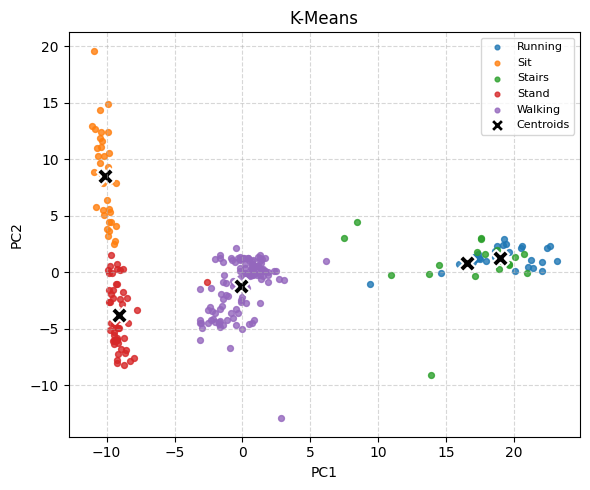

In [28]:
#Create and train the K-Means model
K_means_model = KMeans(
    n_clusters=Nr_clusters,
    init='k-means++', # Smart initialization method
    max_iter=300,
    n_init=10, # Run 10 times with different centroids to find the best result
    random_state=33
)
K_means_model.fit(X_scaled)
K_means_model_labels = K_means_model.labels_ # Get the cluster assignments (labels)

# Supervised-style metrics
acc_km, kappa_km, f1_km, y_km_aligned = eval_supervised_style("K-Means", y_true, K_means_model_labels)

# K-Means plot (centroids available)
plt.figure(figsize=(6, 5))
for lab in np.unique(np.asarray(y_km_aligned)):
    idx = np.asarray(y_km_aligned) == lab
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=18, alpha=0.8, label=str(lab))
# Project KMeans centroids to PCA space and plot
centroids_km_pca = pca.transform(K_means_model.cluster_centers_)
plt.scatter(centroids_km_pca[:, 0], centroids_km_pca[:, 1], marker='X', s=150,
            color='black', edgecolors='white', linewidths=1.5, label='Centroids')
plt.title("K-Means")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=0.8, fontsize=8, loc="best", frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Fuzzy C-means model


--- Fuzzy C-Means (Supervised-style metrics) ---
Accuracy       : 0.7121
Cohen's Kappa  : 0.6401
F1-Score (Macro): 0.6992


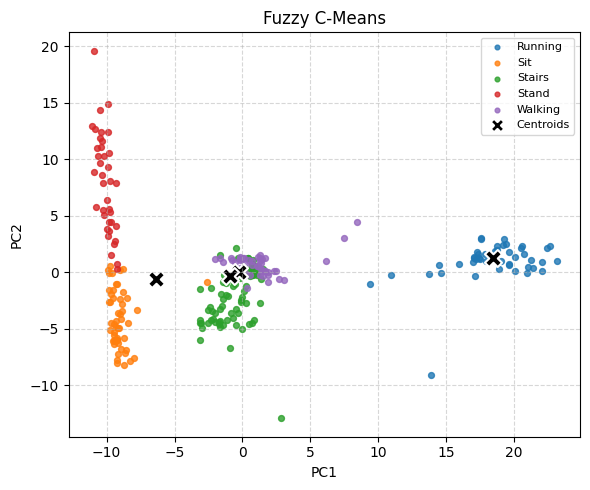

In [29]:
X_scaled_Transposed = X_scaled.T  # Transpose the current dataframe since skfuzzy expects (features, samples)
cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
    data=X_scaled_Transposed,
    c=Nr_clusters,
    m=2.0,
    error=1e-5,
    maxiter=1000,
    init=None,
    seed=33
)
Fuzzy_C_means_model_labels = np.argmax(u, axis=0)

# # Unsupervised metrics
# fcm_sil, fcm_ari, fcm_nmi = eval_unsupervised("Fuzzy C-Means", y, fcm_labels)
# print(f"FCM partition coefficient (FPC): {fpc:.4f}")  # diagnostic
# Supervised-style metrics
acc_fcm, kappa_fcm, f1_fcm, y_fcm_aligned = eval_supervised_style("Fuzzy C-Means", y_true, Fuzzy_C_means_model_labels)

# Fuzzy C-Means plot (cntr contains centers in original feature space)
plt.figure(figsize=(6, 5))
for lab in np.unique(np.asarray(y_fcm_aligned)):
    idx = np.asarray(y_fcm_aligned) == lab
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=18, alpha=0.8, label=str(lab))
# Project FCM centers to PCA space and plot
centroids_fcm_pca = pca.transform(cntr)
plt.scatter(centroids_fcm_pca[:, 0], centroids_fcm_pca[:, 1], marker='X', s=150,
            color='black', edgecolors='white', linewidths=1.5, label='Centroids')
plt.title("Fuzzy C-Means")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale = 0.8, fontsize=8, loc="best", frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Gaussian Mixture model




--- Gaussian Mixture (GMM) (Supervised-style metrics) ---
Accuracy       : 0.6381
Cohen's Kappa  : 0.5439
F1-Score (Macro): 0.6320


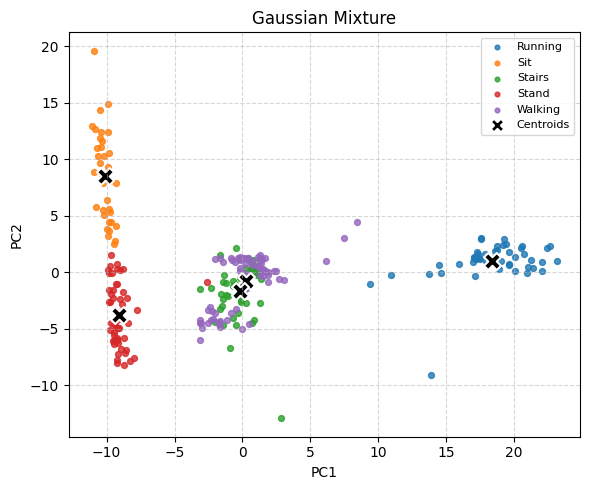

In [31]:
gmm = GaussianMixture(n_components=Nr_clusters, covariance_type="full", random_state=33, n_init=5)
gmm.fit(X_scaled)
gmm_probs = gmm.predict_proba(X_scaled)
gmm_labels = np.argmax(gmm_probs, axis=1)

# # Unsupervised metrics
# gmm_sil, gmm_ari, gmm_nmi = eval_unsupervised("Gaussian Mixture (GMM)", y, gmm_labels)
# Supervised-style metrics
acc_gmm, kappa_gmm, f1_gmm, y_gmm_aligned = eval_supervised_style("Gaussian Mixture (GMM)", y_true, gmm_labels)

# GMM plot (use component means as centroids)
plt.figure(figsize=(6, 5))
for lab in np.unique(np.asarray(y_gmm_aligned)):
    idx = np.asarray(y_gmm_aligned) == lab
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=18, alpha=0.8, label=str(lab))
# Project GMM means to PCA space and plot
centroids_gmm_pca = pca.transform(gmm.means_)
plt.scatter(centroids_gmm_pca[:, 0], centroids_gmm_pca[:, 1], marker='X', s=150,
            color='black', edgecolors='white', linewidths=1.5, label='Centroids')
plt.title("Gaussian Mixture")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=0.8, fontsize=8, loc="best", frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Model Evaluation & Comparison



================ Supervised-Style Metrics Summary ================

 Method  Accuracy  Cohen's Kappa  F1-Score
K-Means  0.552529       0.425804  0.492490
    FCM  0.712062       0.640083  0.699162
    GMM  0.638132       0.543883  0.631993


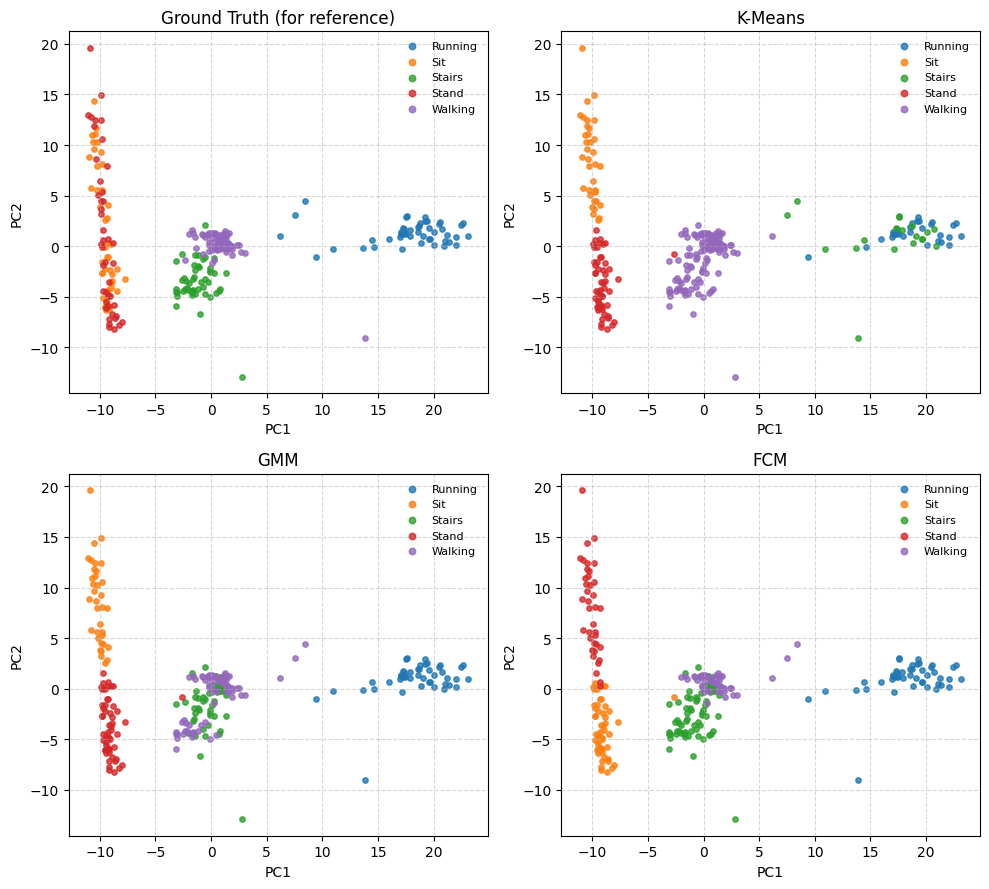

In [44]:
# # Ground Truth plot (no centroids)
# plt.figure(figsize=(6, 5))
# for lab in np.unique(np.asarray(y_true)):
#     idx = np.asarray(y_true) == lab
#     plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=18, alpha=0.8, label=str(lab))
# plt.title("Ground Truth (for reference)")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.legend(markerscale=0.8, fontsize=8, loc="best", frameon=True)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

sup_style_summary = pd.DataFrame([
    ("K-Means", acc_km,  kappa_km,  f1_km),
    ("FCM",     acc_fcm, kappa_fcm, f1_fcm),
    ("GMM",     acc_gmm, kappa_gmm, f1_gmm),
], columns=["Method", "Accuracy", "Cohen's Kappa", "F1-Score"])

print("\n================ Supervised-Style Metrics Summary ================\n")
print(sup_style_summary.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.ravel()

def scatter(ax, Xpca, labels, title):
    for lab in np.unique(labels):
        idx = labels == lab
        ax.scatter(Xpca[idx, 0], Xpca[idx, 1], s=15, alpha=0.8, label=str(lab))
        ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(markerscale=1.2, fontsize=8, loc="best", frameon=False)
    

scatter(axes[0], X_pca, y_true,         "Ground Truth (for reference)")
scatter(axes[1], X_pca, y_km_aligned,   "K-Means")
scatter(axes[2], X_pca, y_gmm_aligned,  "GMM")
scatter(axes[3], X_pca, y_fcm_aligned,  "FCM")


plt.tight_layout()
plt.show()
